In [1]:
!pip install denoising_diffusion_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.6/82.6 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinu

In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import Subset,DataLoader
from denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer
import torch.nn.functional as F
from tqdm import tqdm
class DIPNet(nn.Module):
    def __init__(self):
        super(DIPNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 3, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [3]:
ddpm = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    flash_attn = True
)

ddpm_model = GaussianDiffusion(
    ddpm,
    image_size = 64,
    timesteps = 1000,           # number of steps
    sampling_timesteps = 250    # number of sampling timesteps (using ddim for faster inference [see citation for ddim paper])
)


Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


In [4]:
# load dataset
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # 调整图像大小
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Repeat the image 3 times to create 3 channels
    transforms.Normalize((0.5,), (0.5,))
])
mnist_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)
mnist_loader = DataLoader(mnist_data, batch_size=32, shuffle=True)
indices = np.random.choice(len(mnist_data), 1000, replace=False)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
random_index = np.random.randint(len(mnist_data))
corrupted_image,_ = mnist_data[random_index]
corrupted_image = corrupted_image.unsqueeze(0).to(device)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15022666.85it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 510375.97it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4399713.08it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7917925.51it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [5]:
num_ddpm_epochs = 3
ddpm_optimizer = torch.optim.Adam(ddpm_model.parameters(), lr=2e-5)
ddpm_model.to(device)
for epoch in range(num_ddpm_epochs):  # 訓練10個epoch
    ddpm_model.train()
    for images, _ in tqdm(mnist_loader):
        images = images.to(device)  # 假設使用GPU進行訓練
        ddpm_optimizer.zero_grad()
        loss = ddpm_model(images)
        loss.backward()
        ddpm_optimizer.step()
    print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

  0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(
100%|██████████| 313/313 [02:41<00:00,  1.93it/s]


Epoch 1, Loss: 0.30944764614105225


100%|██████████| 313/313 [02:36<00:00,  2.00it/s]


Epoch 2, Loss: 0.09883296489715576


100%|██████████| 313/313 [02:36<00:00,  2.00it/s]

Epoch 3, Loss: 0.10229350626468658


In [6]:
torch.save(ddpm_model,"./ddpm_model_1.pt")

In [7]:
noise_images = []
for t in range(0, ddpm_model.num_timesteps, ddpm_model.num_timesteps // 10):  # 每 100 个时间步保存一次
    t_tensor = torch.tensor([t], device=device).long()
    with torch.no_grad():
        noisy_image = ddpm_model.q_sample(corrupted_image, t_tensor)
    noise_images.append(noisy_image)

In [8]:
# Train DIP model on MNIST image with ddpm
dip_net = DIPNet().to(device)
dip_optimizer = optim.Adam(dip_net.parameters(), lr=0.01)
dip_criterion = nn.MSELoss()
num_dip_epochs = 1000
loss_with_ddpm = []
ddpm_model.eval()
with torch.no_grad():
  dip_noise = ddpm_model(corrupted_image)
for dip_noise in noise_images:
  for epoch in range(num_dip_epochs):
    dip_optimizer.zero_grad()
    dip_output = dip_net(dip_noise)
    dip_loss = dip_criterion(dip_output, corrupted_image)
    dip_loss.backward()
    dip_optimizer.step()
    print(f'DIP Epoch [{epoch}/{num_dip_epochs}], Loss: {dip_loss.item():.4f}')
    loss_with_ddpm.append(dip_loss.item())

串流輸出內容已截斷至最後 5000 行。
DIP Epoch [0/1000], Loss: 0.0169
DIP Epoch [1/1000], Loss: 0.0173
DIP Epoch [2/1000], Loss: 0.0195
DIP Epoch [3/1000], Loss: 0.0284
DIP Epoch [4/1000], Loss: 0.0825
DIP Epoch [5/1000], Loss: 0.0798
DIP Epoch [6/1000], Loss: 0.0956
DIP Epoch [7/1000], Loss: 0.0202
DIP Epoch [8/1000], Loss: 0.0649
DIP Epoch [9/1000], Loss: 0.1184
DIP Epoch [10/1000], Loss: 0.1151
DIP Epoch [11/1000], Loss: 0.0902
DIP Epoch [12/1000], Loss: 0.0146
DIP Epoch [13/1000], Loss: 0.1944
DIP Epoch [14/1000], Loss: 0.1229
DIP Epoch [15/1000], Loss: 0.1214
DIP Epoch [16/1000], Loss: 0.1189
DIP Epoch [17/1000], Loss: 0.1163
DIP Epoch [18/1000], Loss: 0.2135
DIP Epoch [19/1000], Loss: 4.1373
DIP Epoch [20/1000], Loss: 0.4133
DIP Epoch [21/1000], Loss: 0.6787
DIP Epoch [22/1000], Loss: 0.7097
DIP Epoch [23/1000], Loss: 0.1985
DIP Epoch [24/1000], Loss: 0.2448
DIP Epoch [25/1000], Loss: 0.2152
DIP Epoch [26/1000], Loss: 0.3259
DIP Epoch [27/1000], Loss: 0.1398
DIP Epoch [28/1000], Loss: 0.4014
DIP

In [9]:
loss_with_ddpm = loss_with_ddpm[-1000:]
print(len(loss_with_ddpm))

1000


In [ ]:
torch.save(dip_net, 'dip_model.pt')


In [10]:
# Train DIP model on MNIST image without ddpm
dip_net = DIPNet().to(device)
dip_optimizer = optim.Adam(dip_net.parameters(), lr=0.01)
dip_criterion = nn.MSELoss()
dip_noise = torch.randn_like(corrupted_image).to(device)
loss_without_ddpm = []
num_dip_epochs = 1000
for epoch in range(num_dip_epochs):
    dip_optimizer.zero_grad()
    dip_output = dip_net(dip_noise)
    dip_loss = dip_criterion(dip_output, corrupted_image)
    dip_loss.backward()
    dip_optimizer.step()
    loss_without_ddpm.append(dip_loss.item())
    print(f'DIP Epoch [{epoch}/{num_dip_epochs}], Loss: {dip_loss.item():.4f}')



DIP Epoch [0/1000], Loss: 0.9692
DIP Epoch [1/1000], Loss: 16.2618
DIP Epoch [2/1000], Loss: 0.5208
DIP Epoch [3/1000], Loss: 0.8846
DIP Epoch [4/1000], Loss: 0.8921
DIP Epoch [5/1000], Loss: 0.8940
DIP Epoch [6/1000], Loss: 0.8945
DIP Epoch [7/1000], Loss: 0.8940
DIP Epoch [8/1000], Loss: 0.8925
DIP Epoch [9/1000], Loss: 0.8902
DIP Epoch [10/1000], Loss: 0.8872
DIP Epoch [11/1000], Loss: 0.8837
DIP Epoch [12/1000], Loss: 0.8797
DIP Epoch [13/1000], Loss: 0.8752
DIP Epoch [14/1000], Loss: 0.8704
DIP Epoch [15/1000], Loss: 0.8652
DIP Epoch [16/1000], Loss: 0.8598
DIP Epoch [17/1000], Loss: 0.8541
DIP Epoch [18/1000], Loss: 0.8482
DIP Epoch [19/1000], Loss: 0.8422
DIP Epoch [20/1000], Loss: 0.8360
DIP Epoch [21/1000], Loss: 0.8296
DIP Epoch [22/1000], Loss: 0.8232
DIP Epoch [23/1000], Loss: 0.8166
DIP Epoch [24/1000], Loss: 0.8101
DIP Epoch [25/1000], Loss: 0.8034
DIP Epoch [26/1000], Loss: 0.7968
DIP Epoch [27/1000], Loss: 0.7901
DIP Epoch [28/1000], Loss: 0.7834
DIP Epoch [29/1000], Lo

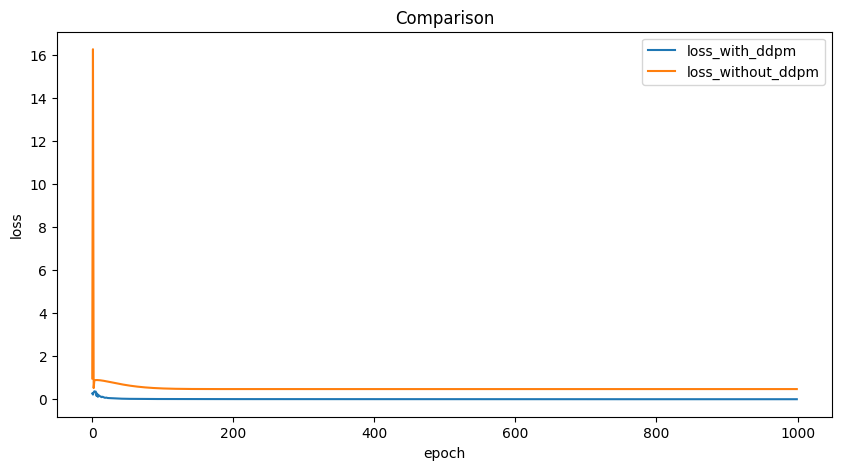

In [12]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))

plt.plot(loss_with_ddpm, label='loss_with_ddpm')
plt.plot(loss_without_ddpm, label='loss_without_ddpm')
plt.title('Comparison')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.savefig('loss comparison.png')
plt.show()